In [ ]:
%%javascript
IPython.notebook.clear_all_output();

# Download dataset

In [3]:
# Download the dataset
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip ut-zap50k-images.zip > /dev/null

--2021-04-15 15:42:11--  http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.120.116
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.120.116|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305323328 (291M) [application/zip]
Saving to: ‘ut-zap50k-images.zip’

100%[======================================>] 305,323,328 45.8MB/s   in 16s    

2021-04-15 15:42:27 (18.7 MB/s) - ‘ut-zap50k-images.zip’ saved [305323328/305323328]



In [2]:
!rm -rf ut-zap50k-images.zip;

In [89]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import matplotlib.image as image
import splitfolders 

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import tensorflow.keras.backend as Backend

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda


In [11]:
dir_name = "./data"
isDir = os.path.isdir(dir_name) 
if not isDir:
    !mkdir data
    !mkdir data/Boots data/Sandals data/Shoes data/Slippers
    !find ut-zap50k-images/Boots -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Boots;
    !find ut-zap50k-images/Sandals -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Sandals;
    !find ut-zap50k-images/Shoes -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Shoes;
    !find ut-zap50k-images/Slippers -type f -print0 | xargs -0 mv -t data/Slippers;
    !rm -rf ut-zap50k-images;

In [13]:
files='**/*.jpg'
filenames = glob(os.path.join(dir_name, files))
classes = [os.path.basename(os.path.dirname(name)) for name in filenames]
count = list(Counter(classes).items())
print("Class count:", count);

Class count: [('Slippers', 1283), ('Sandals', 1500), ('Boots', 1500), ('Shoes', 1500)]


In [16]:
class_names = os.listdir(dir_name) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels
print("Classes:", class_name2id)

labels = [class_name2id[c] for c in classes]
Counter(labels)

Classes: {'Slippers': 0, 'Sandals': 1, 'Boots': 2, 'Shoes': 3}


Counter({0: 1283, 1: 1500, 2: 1500, 3: 1500})

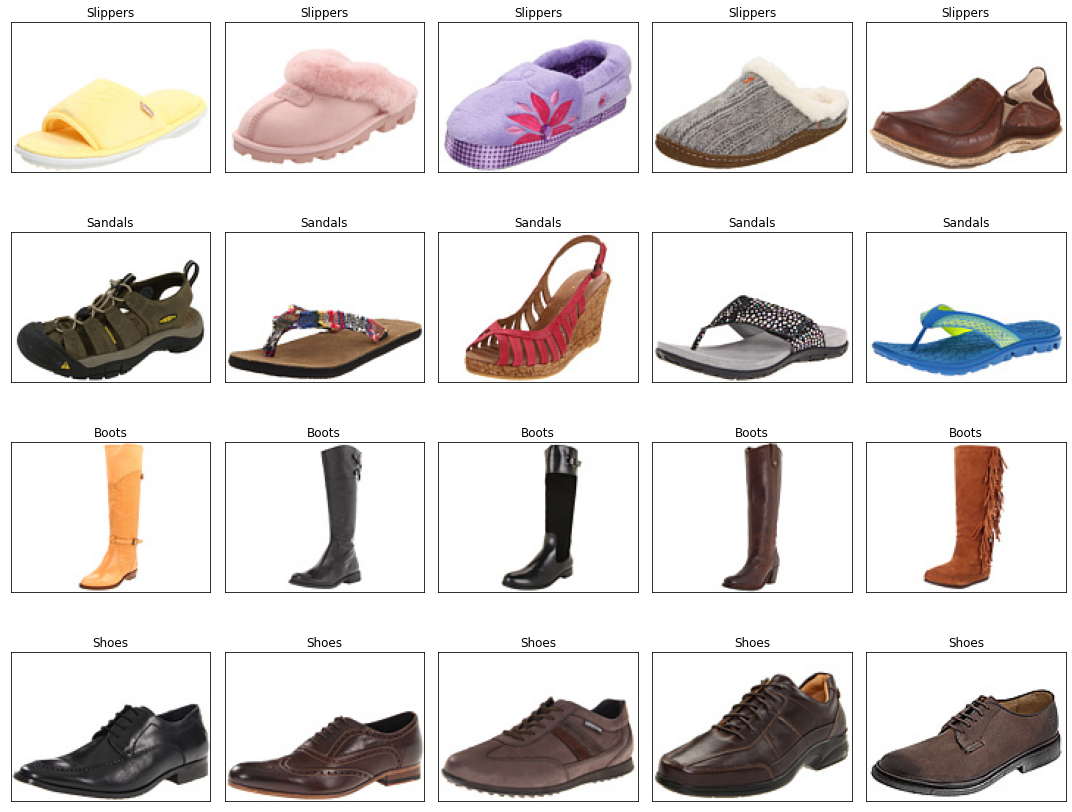

In [33]:
def visual_figure(ax, file, title):
    img = image.imread(file)
    ax.imshow(img)
    ax.title.set_text(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

fig = plt.figure(figsize=(15, 12))
axs = fig.subplots(4, 5)
for i in range(5):
    id_1 = i+count[0][1]
    id_2 = id_1+count[1][1]
    id_3 = id_2+count[2][1]
    visual_figure(axs[0,i], filenames[i], classes[i])
    visual_figure(axs[1,i], filenames[id_1], classes[id_1])
    visual_figure(axs[2,i], filenames[id_2], classes[id_2])
    visual_figure(axs[3,i], filenames[id_3], classes[id_3])
fig.tight_layout()

# Processing dataset

In [35]:
# split dataset into train, test and validation
splitfolders.ratio('data', output="splitted_data", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 5783 files [01:05, 88.09 files/s] 


In [37]:
# config
IMG_SHAPE = (64, 64, 3)
IMG_SIZE = (64, 64) 
BATCH_SIZE = 32
EPOCHS = 64

In [72]:
def get_image(filename):
    img_obj = load_img(filename, target_size=IMG_SIZE) # image object
    numpy_image = img_to_array(img_obj) # image object -> pixel array
    return numpy_image

def map_dataset(filenames):
    data = []
    for i in range(len(filenames)):
        data.append(get_image(filenames[i]))
        if(i % 1000 == 0): print(i, 'images loaded')
    return np.array(data)/255.0

def get_files_labels(path):
    files = glob(os.path.join(path, '**/*.jpg'))
    classes = [os.path.basename(os.path.dirname(name)) for name in files]
    labels = [class_name2id[c] for c in classes]
    return files, np.array(labels)
    

In [70]:
train_path = "splitted_data/train"
train_files, train_y = get_files_labels(train_path)
print("Train:", Counter(train_y))

test_path = "splitted_data/test"
test_files, test_y = get_files_labels(test_path)
print("Test:", Counter(test_y))

val_path = "splitted_data/val"
val_files, val_y = get_files_labels(val_path)
print("Validation:", Counter(val_y))


Train: Counter({1: 1200, 2: 1200, 3: 1200, 0: 1026})
Test: Counter({1: 150, 2: 150, 3: 150, 0: 129})
Validation: Counter({1: 150, 2: 150, 3: 150, 0: 128})


In [73]:
train_X = map_dataset(train_files)
test_X = map_dataset(test_files)
val_X = map_dataset(val_files)

0 images loaded
1000 images loaded
2000 images loaded
3000 images loaded
4000 images loaded
0 images loaded
0 images loaded


In [97]:
print(train_X.shape)
print(train_y.shape)
print(train_X[0])

(4626, 64, 64, 3)
(4626,)
[[[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 ...

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]

 [[1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]
  ...
  [1. 1. 1.]
  [1. 1. 1.]
  [1. 1. 1.]]]


# Make Pairs for Siamese Network

In [119]:
def make_pos_neg_pairs(X, y):
    pairs = [] # (image, image) pair 
    labels = [] # 0 means negative pair, otherwise, positive
    
    class_count = len(np.unique(y))
    class_indexes = [np.where(y == i)[0] for i in range(0, class_count)]
    
    for i in range(len(X)):
        cur_img = X[i]
        cur_label = y[i]
        
        # positive: pick an image from same class randomly
        pos_i = np.random.choice(class_indexes[cur_label]) 
        pos_img = X[pos_i]
        pairs.append([cur_img, pos_img])
        labels.append([1])
        
        # negative: pick an image from other classes randomly
        neg_ids = np.where(y != cur_label)[0]
        neg_img = X[np.random.choice(neg_ids)]        
        pairs.append([cur_img, neg_img])
        labels.append([0])
        
    return (np.array(pairs), np.array(labels))

In [120]:
(train_paris, train_labels) = make_pos_neg_pairs(train_X, train_y)
(val_paris, val_labels) = make_pos_neg_pairs(val_X, val_y)

In [121]:
print(train_paris.shape)
print(train_labels.shape)
print(val_paris.shape)
print(val_labels.shape)

(9252, 2, 64, 64, 3)
(9252, 1)
(1156, 2, 64, 64, 3)
(1156, 1)


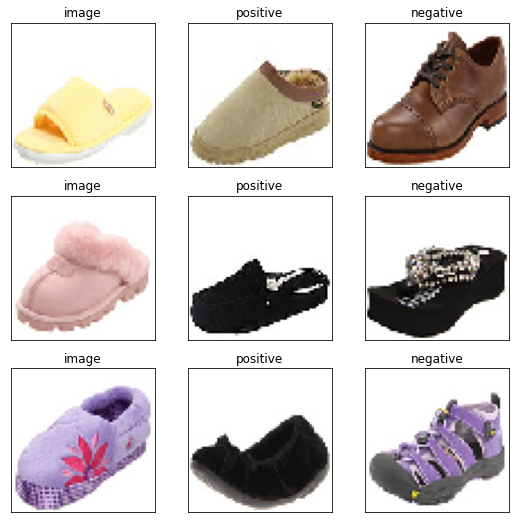

In [124]:
def show(ax, image, title):
    ax.imshow(image)
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig = plt.figure(figsize=(9, 9))
axs = fig.subplots(3, 3)
for i in range(3):
    show(axs[i, 0], train_paris[2*i][0], "image")
    show(axs[i, 1], train_paris[2*i][1], "positive")
    show(axs[i, 2], train_paris[2*i+1][1], "negative")

# Build Siamese Network

In [84]:
def siamese_model(shape, embedding_d=48):
    inputs = Input(shape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    global_pool = GlobalAveragePooling2D()(x)
    outputs = Dense(embedding_d)(global_pool)
    
    model = Model(inputs, outputs)
    
    return model, outputs

In [87]:
def cal_euclidean_distance(vector_tuple):
    (vector_1, vector_2) = vector_tuple
    sqr_sum = Backend.sum(Backend.square(vector_1 - vector_2), axis=1, keepdims=True)
    distance = Backend.sqrt(Backend.maximum(sqr_sum, Backend.epsilon()))
    return distance   

In [91]:
input_1 = Input(shape=IMG_SHAPE)
input_2 = Input(shape=IMG_SHAPE)
ext_features, embedding = siamese_model(IMG_SHAPE)
features_1 = ext_features(input_1)
features_2 = ext_features(input_2)
euc_distance = Lambda(cal_euclidean_distance)([features_1, features_2])
sia_model = Model(inputs=[input_1, input_2], outputs=euc_distance)
sia_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model_3 (Functional)            (None, 48)           20400       input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_3[0][0]              

# Trianing Model 

In [125]:
def cal_loss(y, pred, margin=1):
    y = tf.cast(y, pred.dtype)
    square = Backend.square(pred)
    margin_square = Backend.square(Backend.maximum(margin - pred, 0))
    loss = Backend.mean(y * square + (1 - y) * margin_square)
    return loss

In [127]:
sia_model.compile(loss=cal_loss, optimizer="adam")

history = sia_model.fit(
    [train_paris[:, 0], train_paris[:, 1]], train_labels[:],
    validation_data=([val_paris[:, 0], val_paris[:, 1]], val_labels[:]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)


Epoch 1/64
290/290 [==============================] - 51s 173ms/step - loss: 0.2340 - val_loss: 0.1947
Epoch 2/64
290/290 [==============================] - 50s 172ms/step - loss: 0.1858 - val_loss: 0.1869
Epoch 3/64
290/290 [==============================] - 49s 170ms/step - loss: 0.1827 - val_loss: 0.1961
Epoch 4/64
290/290 [==============================] - 49s 170ms/step - loss: 0.1748 - val_loss: 0.1877
Epoch 5/64
290/290 [==============================] - 49s 169ms/step - loss: 0.1678 - val_loss: 0.1775
Epoch 6/64
290/290 [==============================] - 50s 174ms/step - loss: 0.1669 - val_loss: 0.1689
Epoch 7/64
290/290 [==============================] - 50s 172ms/step - loss: 0.1580 - val_loss: 0.1613
Epoch 8/64
290/290 [==============================] - 50s 171ms/step - loss: 0.1582 - val_loss: 0.1640
Epoch 9/64
290/290 [==============================] - 50s 171ms/step - loss: 0.1518 - val_loss: 0.1723
Epoch 10/64
290/290 [==============================] - 47s 163ms/step - l

In [132]:
# print(history.history["loss"])

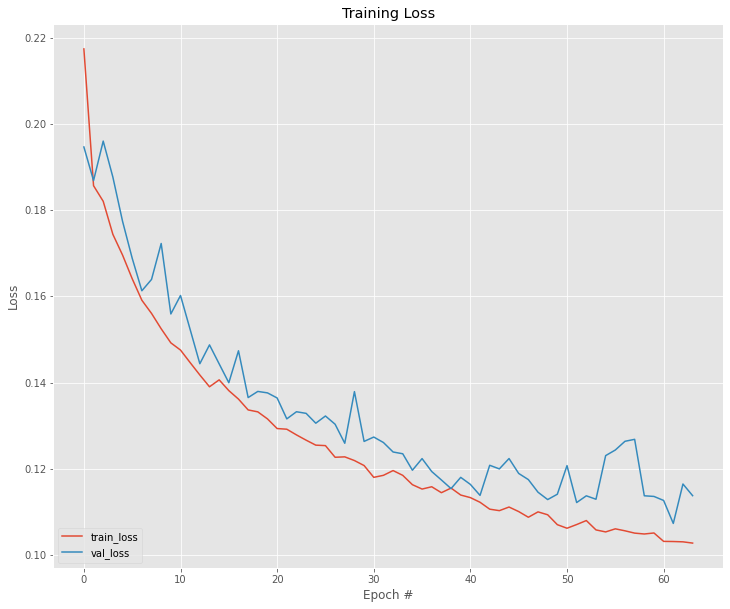

In [136]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [166]:
(test_paris, test_labels) = make_pos_neg_pairs(test_X, test_y)

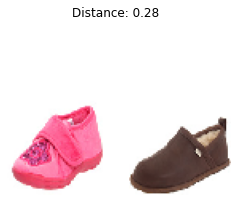

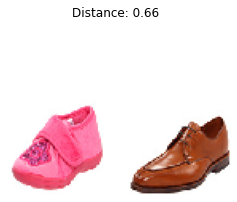

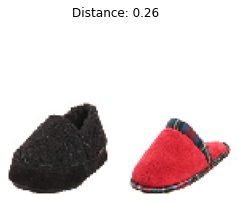

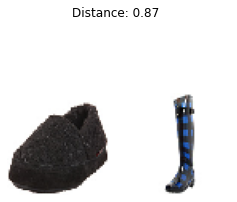

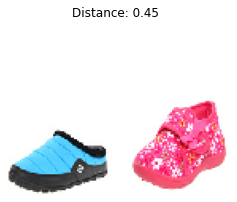

In [177]:


for i in range(5):
    imageA = np.expand_dims(test_paris[i][0], axis=0)
    imageB = np.expand_dims(test_paris[i][1], axis=0)
    preds = sia_model.predict([imageA, imageB])
    proba = preds[0][0]
    
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 4))
    plt.suptitle("Distance: {:.2f}".format(proba))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(test_paris[i][0])
    plt.axis("off")
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(test_paris[i][1])
    plt.axis("off")
    
    plt.show()
    

In [180]:
# def show(ax, image, title):
#     ax.imshow(image)
#     ax.set_title(title)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    
# fig = plt.figure(figsize=(6, 6))
# axs = fig.subplots(2, 2)
# for i in range(2):
#     show(axs[i, 0], test_X[i*2], "")
#     show(axs[i, 1], test_X[i*2+1], "")

In [147]:
# preds = sia_model.predict([test_X[0], test_X[1]])

In [178]:
# imageA = np.expand_dims(test_X[0], axis=0)
# imageB = np.expand_dims(test_X[5], axis=0)

In [155]:
# preds = sia_model.predict([imageA, imageB])

In [179]:
# print(preds)